<a target="_blank" href="https://colab.research.google.com/github/taobrienlbl/advanced_earth_science_data_analysis/blob/spring_2023_iub/lessons/12_spectral_analysis_continued/12_workalong_01_filter.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Simple filtering

This notebook demonstrates using the FFT to filter timeseries data.  It also demonstrates a higher-quality approach using a [Butterworth fitler](https://en.wikipedia.org/wiki/Butterworth_filter).

In [1]:
""" Import libraries. """
import numpy as np
import numpy.fft as fft
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
""" Load the data file. """
discharge_url = "https://raw.githubusercontent.com/taobrienlbl/advanced_earth_science_data_analysis/spring_2023_iub/lessons/11_spectral_analysis_intro/cannelton_flow.dat"
discharge_df = pd.read_csv(discharge_url, sep= '\t', skiprows=30, header=None, 
                             names = ['agency', 'site', 'date', 'discharge', 'flag'], parse_dates=['date'])
discharge_df.head()

,agency,site,date,discharge,flag
0,USGS,3303280,1975-10-01,94800,A
1,USGS,3303280,1975-10-02,79900,A
2,USGS,3303280,1975-10-03,69000,A
3,USGS,3303280,1975-10-04,74700,A
4,USGS,3303280,1975-10-05,71700,A


In [3]:
""" Filter the data using a naive cutoff filter. """

# get the fourier transform
discharge_fft = fft.rfft(discharge_df['discharge'])

# get the frequencies
dt = 1  # day
dt = dt * 24*60*60  # seconds
freqs = fft.rfftfreq(len(discharge_df['discharge']), dt)

# define the cutoff frequency: 0.5 years
cutoff_period = 0.5  # years
cutoff_period *= 365.25*24*60*60  # seconds
cutoff_freq = 1/cutoff_period  # Hz

# find frequencies that are higher than the cutoff
discharge_fft_filtered = discharge_fft.copy()
discharge_fft_filtered[freqs>cutoff_freq] = 0

# invert the fft to get the filtered timeseries
discharge_filtered = fft.irfft(discharge_fft_filtered)

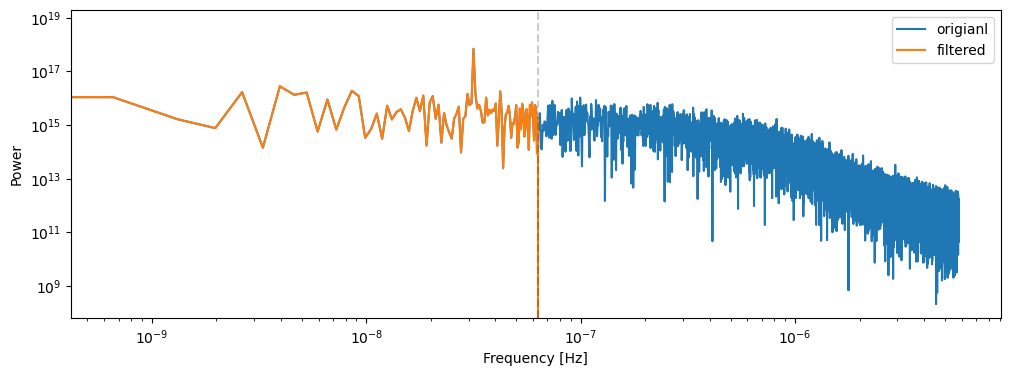

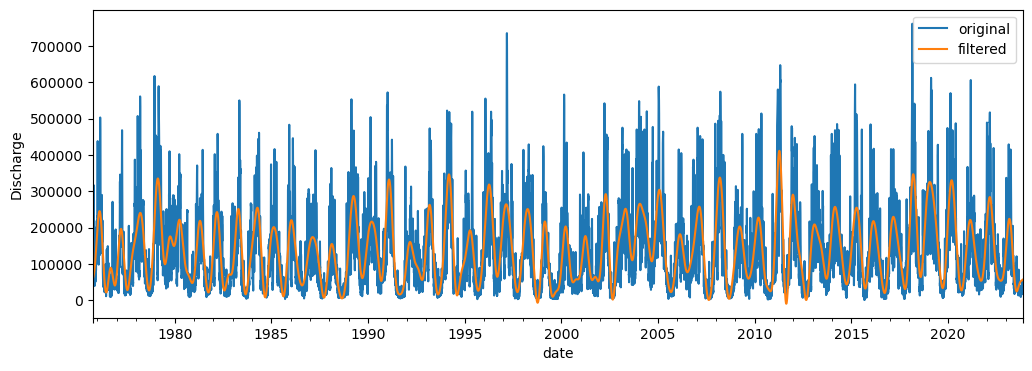

In [4]:
# plot the original and filtered spectrum
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(freqs, np.abs(discharge_fft)**2, label='origianl')
ax.plot(freqs, np.abs(discharge_fft_filtered)**2, label='filtered')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Power")
# draw a line at the cutoff frequency
ax.axvline(cutoff_freq, color="k", linestyle="--", alpha=0.2)
ax.legend()
plt.show()

# plot the original and filtered timeseries
fig, ax = plt.subplots(figsize=(12,4))
discharge_df.plot(ax=ax, x='date', y='discharge', label='original')
ax.plot(discharge_df['date'], discharge_filtered, label='filtered')
ax.set_ylabel('Discharge')
ax.legend()
plt.show()

In [5]:
from scipy.signal import butter, filtfilt

In [6]:
""" Filter the data using a Butterworth filter. """

# define the Butterworth filter properties
order = 5   # filter order

# get the Nyquist frequency
nyquist_freq = 1 / (2*dt)

# define the cutoff frequency: 0.5 years
cutoff_period = 0.5  # years
cutoff_period *= 365.25*24*60*60  # seconds
cutoff_freq = 1/cutoff_period  # Hz
cutoff_freq_norm = cutoff_freq/nyquist_freq

# get the butterworth filter coefficients
b, a = butter(order, cutoff_freq_norm, btype='lowpass')

# apply the butterworth filter
discharge_butter = filtfilt(b, a, discharge_df['discharge'])

# get the FFT of the filtered timeseries
discharge_butter_fft = fft.rfft(discharge_butter)

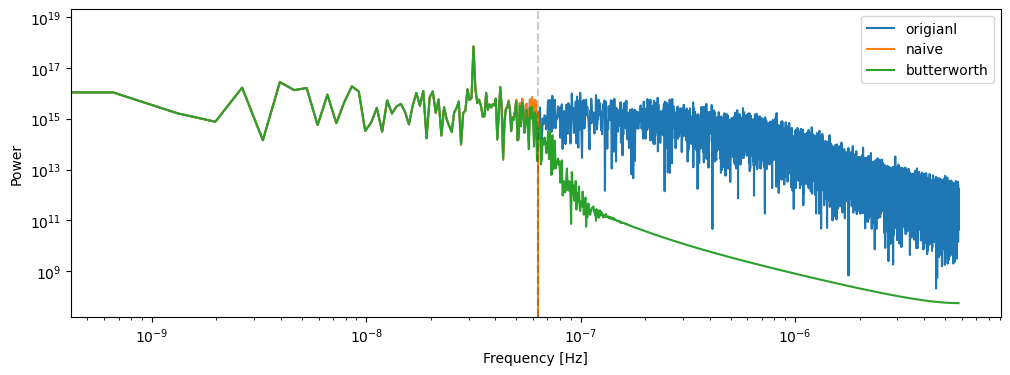

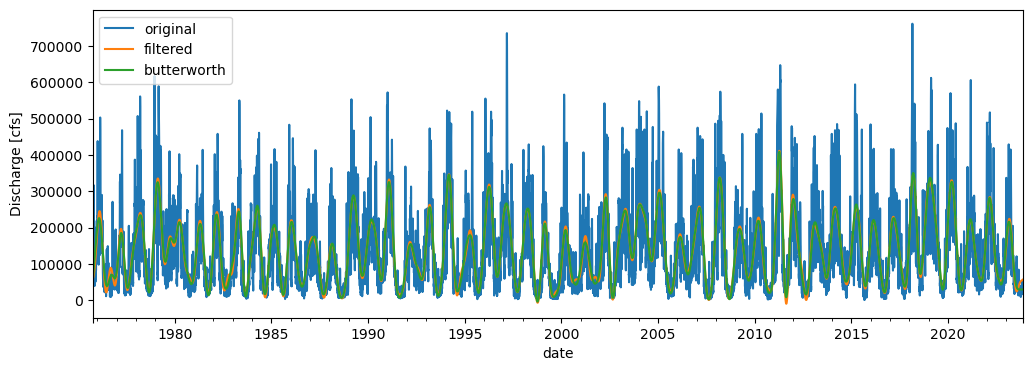

In [7]:
""" Plot all the power spectrums and timeseries """

# plot three power spectrums
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(freqs, np.abs(discharge_fft)**2, label='origianl')
ax.plot(freqs, np.abs(discharge_fft_filtered)**2, label='naive')
ax.plot(freqs, np.abs(discharge_butter_fft)**2, label='butterworth')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Power")
# draw a line at the cutoff frequency
ax.axvline(cutoff_freq, color="k", linestyle="--", alpha=0.2)
ax.legend()
plt.show()

# plot three timeseries
fig, ax = plt.subplots(figsize=(12,4))
discharge_df.plot(ax=ax, x='date', y='discharge', label='original')
ax.plot(discharge_df['date'], discharge_filtered, label='filtered')
ax.plot(discharge_df["date"], discharge_butter, label='butterworth')
ax.set_ylabel('Discharge [cfs]')
ax.legend()
plt.show()

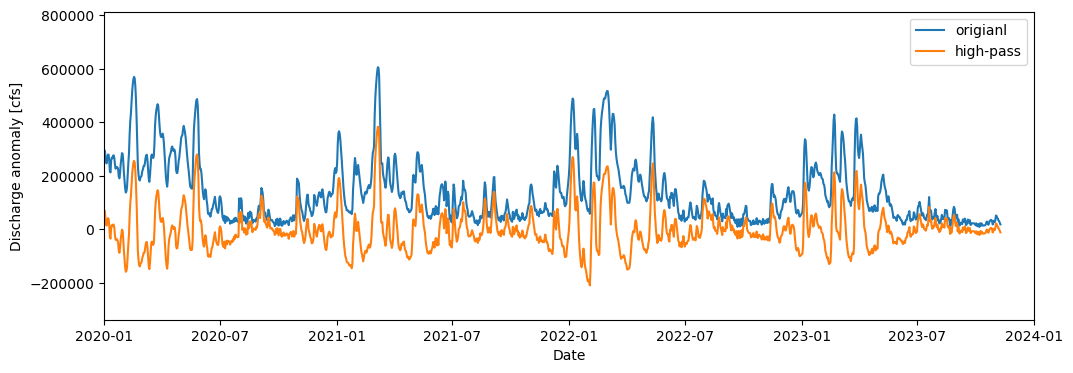

In [8]:
""" Calculate and plot the high-pass data """

# calculate the high-pass data
discharge_highpass = discharge_df["discharge"] - discharge_butter

# plot the high-pass data
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(discharge_df['date'], discharge_df['discharge'], label='origianl')
ax.plot(discharge_df['date'], discharge_highpass, label='high-pass')
ax.set_xlabel("Date")
ax.set_ylabel("Discharge anomaly [cfs]")
ax.set_xlim(pd.Timestamp("2020-01-01"), pd.Timestamp("2024-01-01"))
ax.legend()
plt.show()
